### Cat Breed Detector
- Train own model
-  Retrain model

In [14]:
import torch
import numpy as np
import pandas as pd
import torchvision as tv
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from IPython import display
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import gradio as gr
import seaborn as sn
import tqdm
import wandb
#wandb.login('55b8041cd6000bec97e443682816312bd58b6304')

### Let's get the data
- A folder called 'datasets' is present in the directory. It contains all data gathered from Kaggle.
- Use transform (experiment with transformations)

In [15]:
transform = tv.transforms.Compose([tv.transforms.Resize(256),
                                tv.transforms.CenterCrop(256),
                                tv.transforms.ToTensor()])

training_data_complete = tv.datasets.ImageFolder(
    root= './datasets/',
    transform=transform
)

print('Amount of training images: {}'.format(len(training_data_complete)))
print('Amount of training classes and their indices: {}'.format(training_data_complete.class_to_idx))

Amount of training images: 5625
Amount of training classes and their indices: {'Abyssinian': 0, 'American Bobtail': 1, 'American Shorthair': 2, 'Bengal': 3, 'Birman': 4, 'Bombay': 5, 'British Shorthair': 6, 'Egyptian Mau': 7, 'Maine Coon': 8, 'Persian': 9, 'Ragdoll': 10, 'Russian Blue': 11, 'Siamese': 12, 'Sphynx': 13, 'Tuxedo': 14}


### Split up the data intro training, validation and test set 
- This code is similar to the one professor Tassel showed us in the PR ML&DL course in almost all examples https://nbviewer.org/github/ingambe/PracticumAAUDeepLearning/tree/master/2-Linear-networks/Slides/
- I used 80% as size for the training data  

In [16]:
training_size = int(0.8 * len(training_data_complete))
validation_size = len(training_data_complete) - training_size
training_data, validation_data = torch.utils.data.random_split(training_data_complete, [training_size, validation_size], generator=torch.Generator().manual_seed(0))

training_size = int(0.8 * len(training_data))
test_size = len(training_data) - training_size
training_data, test_data = torch.utils.data.random_split(training_data, [training_size, test_size], generator=torch.Generator().manual_seed(0))

print('Amount of training images: {}'.format(training_size))
print('Amount of validation images: {}'.format(validation_size))
print('Amount of test images: {}'.format(test_size))

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
validation_dataloader =  DataLoader(validation_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, shuffle=False)

Amount of training images: 3600
Amount of validation images: 1125
Amount of test images: 900


I had a lot of troubles with finding a model which didn't bring my PC out of memory and to basically die.
Following website offered me the final hint of how to combine the layers to achieve:
- https://debuggercafe.com/pytorch-imagefolder-for-training-cnn-models/
The model below is very much inspired by the model on this tutorial as without the reshaping and pooling I wasn't able to achieve any result.

In [26]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.c1 = nn.Conv2d(3,20,5)
        self.c2 = nn.Conv2d(20,50,5)
        self.c3 = nn.Conv2d(50,100,5)
        self.c4 = nn.Conv2d(100,160,5)

        self.lin1 = nn.Linear(160,15)

        self.relu = nn.ReLU()

        self.maxpool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.relu(self.c1(x))
        x = self.maxpool(x)
        x = self.relu(self.c2(x))
        x = self.maxpool(x)
        x = self.dropout(x)
        x = self.relu(self.c3(x))
        x = self.maxpool(x)
        x = self.relu(self.c4(x))
        x = self.maxpool(x)
        #  begin This code is copied from https://debuggercafe.com/pytorch-imagefolder-for-training-cnn-models/
        bs, _, _ = x.shape
        x = nn.functional.adaptive_avg_pool2d(x,1).reshape(bs, -1)
        # end
        return self.lin1(x)

In [18]:
def training_and_validation_loop(model, train_loss_list, valid_loss_list, train_acc_list, valid_acc_list, epochs):
    lr = 1e-3
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        print('Training loop')
        loss = 0
        classified_correctly = 0
        epoch_loss = 0
        counter = 0
        for image, label in train_dataloader:
            counter += 1
            optimizer.zero_grad()
            prediction = model(image)
            loss = criterion(prediction, label)

            _, predictions = torch.max(prediction.data, 1)
            classified_correctly += (predictions == label).sum().item()

            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()

        train_loss = epoch_loss / counter
        train_acc = classified_correctly / training_size # = amount of samples
        print('Train loss', train_loss, 'Train acc', train_acc)

        with torch.no_grad():
            print('Validation loop')
            loss = 0
            classified_correctly = 0
            epoch_loss = 0
            counter = 0
            for image, label in validation_dataloader:
                counter += 1
                optimizer.zero_grad()
                prediction = model(image)
                loss = criterion(prediction, label)

                _, predictions = torch.max(prediction.data, 1)
                classified_correctly += (predictions == label).sum().item()

                epoch_loss += loss.item()

            valid_loss = epoch_loss / counter
            valid_acc = classified_correctly / validation_size # = amount of samples
            print('Valid loss', valid_loss, 'Valid acc', valid_acc)
            wandb.log({'Train_accuracy': train_acc, 'Validation_accuracy': valid_acc, 'Training_loss': train_loss, 'Validation_loss': valid_loss})
        
        train_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)
        train_acc_list.append(train_acc*100)
        valid_acc_list.append(valid_acc*100)

### Load pretrained model

In [19]:
model = tv.models.resnet18(pretrained=True)
wandb.init(project="Resnet18")
           
# only train last layer
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(512, 15)

training_loss=[]
validation_loss=[]
training_accuracy=[]
validation_accuracy=[]

training_and_validation_loop(model, training_loss,validation_loss,training_accuracy,validation_accuracy, 8)


### Train own model


In [21]:
model = Net()
wandb.init(project="simpler_Cats")
training_loss=[]
validation_loss=[]
training_accuracy=[]
validation_accuracy=[]

training_and_validation_loop(model, training_loss,validation_loss,training_accuracy,validation_accuracy, 20)
torch.save(model, "./{}.pt".format('own model'))

Train_accuracy,▁
Training_loss,▁
Validation_accuracy,▁
Validation_loss,▁
Train_accuracy,0.0675
Training_loss,36.16973
Validation_accuracy,0.06133
Validation_loss,2.7082


Training loop


100%|██████████| 57/57 [44:28<00:00, 46.82s/it] 


Train loss 2.7418171899360524 Train acc 0.06333333333333334
Validation loop


 11%|█         | 2/18 [00:40<05:21, 20.08s/it]


KeyboardInterrupt: 

In [24]:
def test_on_testset(model, test_set):
    true_labels = []
    predicted_labels = []
    model.eval()
    for data, labels in test_set:
        true_labels.extend(labels.detach().numpy())
        with torch.no_grad():
            prediction = model(data)
            pred_labels = torch.argmax(prediction, dim=1)
            predicted_labels.extend(pred_labels.detach().numpy())
    
    report = classification_report(true_labels, predicted_labels)
    print(report)
    # Showing Confusion Matrix in form of 2D Numpy array
    matrix = confusion_matrix(true_labels, predicted_labels)
    labels_cats = training_data_complete.classes
    
    matrix_df = pd.DataFrame(matrix, index = labels_cats, columns = labels_cats)
    plt.figure(figsize = (10,7))
    cfm_plot = sn.heatmap(matrix_df, annot=True)
    cfm_plot.set(xlabel='Predicted label', ylabel='True label')
    cfm_plot.figure.savefig("cfm.png")

- Load model and test it on test set

              precision    recall  f1-score   support

           0       0.92      0.70      0.80        70
           1       0.51      0.41      0.46        51
           2       0.62      0.47      0.54        64
           3       0.64      0.87      0.73        54
           4       0.74      0.76      0.75        59
           5       0.84      0.96      0.90        67
           6       0.73      0.68      0.71        53
           7       0.82      0.72      0.76        74
           8       0.74      0.90      0.81        60
           9       0.89      0.91      0.90        46
          10       0.76      0.64      0.69        64
          11       0.85      0.90      0.88        63
          12       0.84      0.95      0.89        61
          13       0.98      0.98      0.98        56
          14       0.82      0.95      0.88        58

    accuracy                           0.79       900
   macro avg       0.78      0.79      0.78       900
weighted avg       0.78   

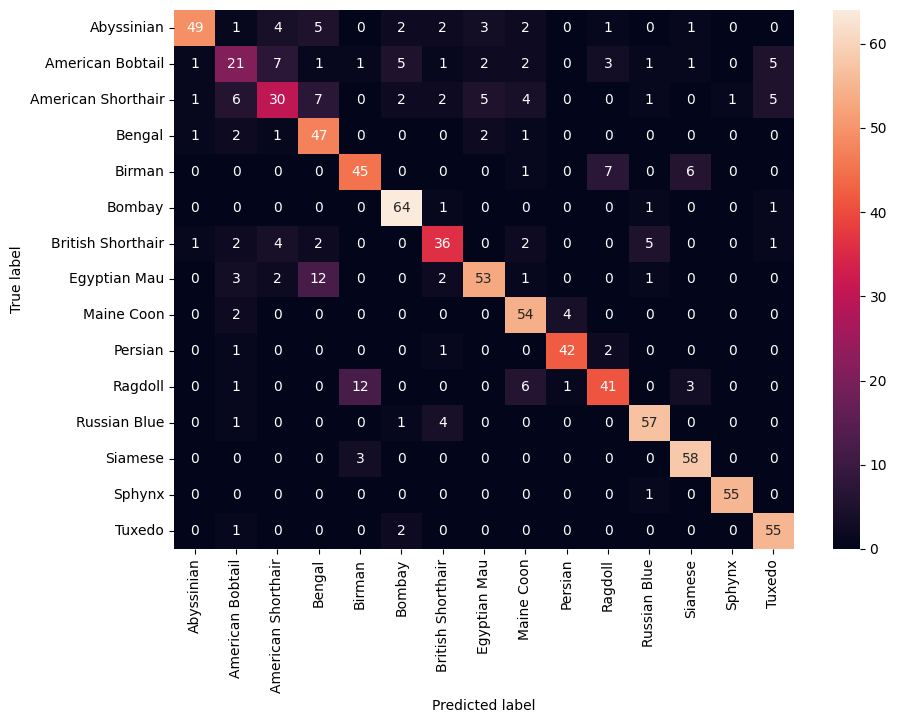

In [29]:
model = torch.load("resnet18-pretrained.pt")
test_on_testset(model, test_dataloader)

model = torch.load("own.pt")
test_on_testset(model, test_dataloader)


### User Interface 
- This code is inspired by the code of the notebook of Prof. Tassel from the course MLDL PR WS22/23.
- I used most of the code of the UI from this notebook and adapted it for my needs; https://nbviewer.org/github/ingambe/PracticumAAUDeepLearning/blob/master/4-CNN/Slides/3b-Gradio.ipynb

In [ ]:
model = torch.load("resnet18-pretrained.pt")

labels_cats = training_data_complete.classes

def gr_func(image):
    image = tv.torchvision.transforms.Resize(256)(tv.torchvision.transforms.ToTensor()(image).unsqueeze(0))

    #print(img)
    with torch.inference_mode():
        prediction = torch.nn.functional.softmax(model(image)[0], dim=0)
        print(prediction)
        labels = {labels_cats[i]: float(prediction[i]) for i in range(len(labels_cats))}
    return labels

interface = gr.Interface(gr_func, 
                     inputs=gr.Image(), 
                     outputs=gr.Label(num_top_classes=15), 
                     live=True, 
                     title="Cat Breed Detector",
                     description="Upload an image of your cat and get to know its breed!",
                     interpretation='default').launch(share=True)